# Content-based recommender using pretrained BERT language model
## Additional exploratory analysis of the MovieLens 100k dataset

### project in work

MovieLens 100K Dataset taken from: https://grouplens.org/datasets/movielens/100k/

In [1]:
import torch
from dateutil import parser
import itertools
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from collections import Counter, OrderedDict
from statistics import mean 
import random
import os
import datetime
import torch.nn as nn
import torch.optim as optim
import csv 
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity


C:\Users\Nadine\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
names=['User_Id', 'Movie_Id', 'Rating', 'Timestamp']
ratings = pd.read_csv('data/ml-100k/u.data', names=names, sep='\t', encoding='latin-1')

names = ['Movie_Id', 'Title', 'Release_Year', 'Video_Release_Date', 'IMDb_URL', 'Unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('data/ml-100k/u.item', names=names, sep='|', encoding='latin-1')

names = ['User_Id', 'Age', 'Gender', 'Occupation', 'ZIP_Code']
users = pd.read_csv('data/ml-100k/u.user', names=names, sep='|', encoding='latin-1')


In [3]:
movies.head(3)

,Movie_Id,Title,Release_Year,Video_Release_Date,IMDb_URL,Unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
movies['Video_Release_Date'] = movies['Release_Year']

movies['Release_Year'] = movies['Title'].str[-5:-1]
movies['Title'] = movies['Title'].str[0:-7]

movies.head(2)

,Movie_Id,Title,Release_Year,Video_Release_Date,IMDb_URL,Unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye,1995,01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0


Edited the release year and release date data

In [5]:
result = [''] * len(movies['Movie_Id'])
genres = ['Unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
for col in genres:
    i = 0
    for value in movies[col]:
        if value == 1:
            result[i] = result[i] + ',' + movies[col].name
        else:
            result[i] = result[i]
        i += 1
        
movies['Genres'] = result
movies['Genres'] = movies['Genres'].str[1:]


In [6]:
movies = movies[['Movie_Id', 'Title', 'Release_Year', 'Video_Release_Date', 'IMDb_URL', 'Genres']]
movies.set_index('Movie_Id', inplace = True)
movies.head(2)

,Title,Release_Year,Video_Release_Date,IMDb_URL,Genres
Movie_Id,,,,,
1,Toy Story,1995,01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,"Animation,Childrens,Comedy"
2,GoldenEye,1995,01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,"Action,Adventure,Thriller"


Added genre information as strings to movies and removed the binary genre information

In [7]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   User_Id    100000 non-null  int64
 1   Movie_Id   100000 non-null  int64
 2   Rating     100000 non-null  int64
 3   Timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [8]:
print(f"{len(ratings['Movie_Id'].unique())} unique users in ratings")
print(f"{len(ratings['Movie_Id'].unique())} unique movies in ratings")


1682 unique users in ratings
1682 unique movies in ratings


100,000 Ratings total by 943 unique users on 1682 unique movies

In [9]:
ratings['Rating'].describe().T

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: Rating, dtype: float64

The 100,000 ratings have a mean rating value of 3.529. The ratings scale goes from 1 to 5.

In [10]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1682 entries, 1 to 1682
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Title               1682 non-null   object
 1   Release_Year        1682 non-null   object
 2   Video_Release_Date  1681 non-null   object
 3   IMDb_URL            1679 non-null   object
 4   Genres              1682 non-null   object
dtypes: object(5)
memory usage: 78.8+ KB


1 movie misses a Video_Release_Date value and 3 movies miss IMDb_URL information.

In [11]:
movies.describe(exclude=np.number).T

,count,unique,top,freq
Title,1682,1659,That Darn Cat!,3
Release_Year,1682,76,1996,297
Video_Release_Date,1681,240,01-Jan-1995,215
IMDb_URL,1679,1660,http://us.imdb.com/M/title-exact?Designated%20...,2
Genres,1682,216,Drama,376


- Only 1659 unique movie titles compared to the movie count of 1682 --> Check the duplicates
- Only 1660 unique IMDB urls compared to the movie count of 1682 --> Check the duplicates
- 76 different release years

In [12]:
print(len(movies[movies.duplicated()]))
duplicates = movies[movies.duplicated(keep=False)]
duplicates = duplicates.sort_values(by=['Title'])
duplicates

18


,Title,Release_Year,Video_Release_Date,IMDb_URL,Genres
Movie_Id,,,,,
670,Body Snatchers,1993,01-Jan-1993,http://us.imdb.com/M/title-exact?Body%20Snatch...,"Horror,Sci-Fi,Thriller"
573,Body Snatchers,1993,01-Jan-1993,http://us.imdb.com/M/title-exact?Body%20Snatch...,"Horror,Sci-Fi,Thriller"
1650,"Butcher Boy, The",1998,01-Jan-1998,http://us.imdb.com/M/title-exact?imdb-title-11...,Drama
1645,"Butcher Boy, The",1998,01-Jan-1998,http://us.imdb.com/M/title-exact?imdb-title-11...,Drama
1234,Chairman of the Board,1998,01-Jan-1998,http://us.imdb.com/Title?Chairman+of+the+Board...,Comedy
1654,Chairman of the Board,1998,01-Jan-1998,http://us.imdb.com/Title?Chairman+of+the+Board...,Comedy
246,Chasing Amy,1997,01-Jan-1997,http://us.imdb.com/M/title-exact?Chasing+Amy+(...,"Drama,Romance"
268,Chasing Amy,1997,01-Jan-1997,http://us.imdb.com/M/title-exact?Chasing+Amy+(...,"Drama,Romance"
1606,Deceiver,1997,01-Jan-1997,http://us.imdb.com/M/title-exact?Liar+(1997),Crime


18 movies exist multiple times with different ids.

Check if all used movie ids are used in the rating dataset.

In [13]:
for el in duplicates.index:
    movie_id = el
    if movie_id in ratings['Movie_Id']:
        print(f'Movie_Id {movie_id} is in ratings')
    else:
        print(f'Movie_Id {movie_id} is not in ratings')

Movie_Id 670 is in ratings
Movie_Id 573 is in ratings
Movie_Id 1650 is in ratings
Movie_Id 1645 is in ratings
Movie_Id 1234 is in ratings
Movie_Id 1654 is in ratings
Movie_Id 246 is in ratings
Movie_Id 268 is in ratings
Movie_Id 1606 is in ratings
Movie_Id 309 is in ratings
Movie_Id 1257 is in ratings
Movie_Id 1256 is in ratings
Movie_Id 348 is in ratings
Movie_Id 329 is in ratings
Movie_Id 500 is in ratings
Movie_Id 304 is in ratings
Movie_Id 1617 is in ratings
Movie_Id 1175 is in ratings
Movie_Id 1607 is in ratings
Movie_Id 1395 is in ratings
Movie_Id 305 is in ratings
Movie_Id 865 is in ratings
Movie_Id 680 is in ratings
Movie_Id 266 is in ratings
Movie_Id 876 is in ratings
Movie_Id 881 is in ratings
Movie_Id 1625 is in ratings
Movie_Id 1477 is in ratings
Movie_Id 1680 is in ratings
Movie_Id 1429 is in ratings
Movie_Id 1658 is in ratings
Movie_Id 711 is in ratings
Movie_Id 1003 is in ratings
Movie_Id 878 is in ratings
Movie_Id 303 is in ratings
Movie_Id 297 is in ratings


All duplicate movie ids are used in the ratings dataset. Next step: replace the duplicated ids.

In [14]:
replaced_ids = {}
i = 0
id_to_keep = 0
id_to_replace = 0
while i < len(duplicates.index):
    el = duplicates.index[i]
    if i % 2 == 0:
        id_to_keep = el
        i += 1
    else:
        id_to_replace = el
        replaced_ids[id_to_replace] = id_to_keep
        i += 1
print(replaced_ids)

{573: 670, 1645: 1650, 1654: 1234, 268: 246, 309: 1606, 1256: 1257, 329: 348, 304: 500, 1175: 1617, 1395: 1607, 865: 305, 266: 680, 881: 876, 1477: 1625, 1429: 1680, 711: 1658, 878: 1003, 297: 303}


In [15]:
ratings['Movie_Id'] = ratings['Movie_Id'].apply(lambda x: replaced_ids[x] if x in replaced_ids else x)

In [16]:
ratings.loc[ratings['Movie_Id'] == 573]

,User_Id,Movie_Id,Rating,Timestamp


Check if Movie Ids still exist in ratings: No, movie Ids have been successfully replaced.

Next: Remove the replaced ids from the movie dataset and create new Ids for all movies

In [17]:
desired_indices = [i for i in movies.index.values if i not in replaced_ids]
movies = movies.loc[desired_indices]

The exemplary movie id has been successfully removed from the movie dataset

In [18]:
movies.describe(exclude=np.number).T

,count,unique,top,freq
Title,1664,1659,That Darn Cat!,2
Release_Year,1664,76,1996,295
Video_Release_Date,1663,240,01-Jan-1995,215
IMDb_URL,1661,1660,http://us.imdb.com/M/title-exact?imdb-title-11...,2
Genres,1664,216,Drama,370


Two movies have missing IMDB information, which is currently not relevant for the envisioned recommendation task

#### Reindexing of movie ids after deleting the duplicates

In [19]:
i = 0
indices_new = []
indices_dict = {}

for index in movies.index.values:
    indices_dict[index] = i
    indices_new.append(i)
    i += 1

movies.index = indices_new    

In [20]:
movies.head(2)

,Title,Release_Year,Video_Release_Date,IMDb_URL,Genres
0,Toy Story,1995,01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,"Animation,Childrens,Comedy"
1,GoldenEye,1995,01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,"Action,Adventure,Thriller"


#### Applying new movie ids to ratings dataset

In [21]:
ratings.head(1)

,User_Id,Movie_Id,Rating,Timestamp
0,196,242,3,881250949


In [22]:
indices_new = []
for index in ratings['Movie_Id']:
    if index in indices_dict:
        indices_new.append(indices_dict[index])
ratings['Movie_Id'] = indices_new


In [24]:
ratings.head(1)

,User_Id,Movie_Id,Rating,Timestamp
0,196,241,3,881250949


In [25]:
users.head(2)

,User_Id,Age,Gender,Occupation,ZIP_Code
0,1,24,M,technician,85711
1,2,53,F,other,94043


In [26]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   User_Id     943 non-null    int64 
 1   Age         943 non-null    int64 
 2   Gender      943 non-null    object
 3   Occupation  943 non-null    object
 4   ZIP_Code    943 non-null    object
dtypes: int64(2), object(3)
memory usage: 37.0+ KB


In [27]:
len(users['User_Id'].value_counts())

943

The users dataset contains information about 943 unique users and contains no missing values for any user attribute

In [28]:
users.describe().T

,count,mean,std,min,25%,50%,75%,max
User_Id,943.0,472.000000,272.364951,1.0,236.5,472.0,707.5,943.0
Age,943.0,34.051962,12.192740,7.0,25.0,31.0,43.0,73.0


The mean user age is 34 years, with the lowest age specification being 7 and the oldest 73.

In [29]:
users['Gender'].value_counts()

Gender
M    670
F    273
Name: count, dtype: int64

In [30]:
users['Occupation'].value_counts()

Occupation
student          196
other            105
educator          95
administrator     79
engineer          67
programmer        66
librarian         51
writer            45
executive         32
scientist         31
artist            28
technician        27
marketing         26
entertainment     18
healthcare        16
retired           14
lawyer            12
salesman          12
none               9
homemaker          7
doctor             7
Name: count, dtype: int64

### Run Preprocessing for visualisation of genre interests grouped by user characteristics

In [31]:
user_genders = {}
for idx, row in users.iterrows():
    gender = users.loc[idx, 'Gender']
    user_id = users.loc[idx, 'User_Id']
    user_genders[user_id] = gender

age_bins = {}
bin_size = 20
age_bin = bin_size
for age in range(100+1):
    if age % bin_size == 0:
        age_bin = age + bin_size
    age_bins[age] = age_bin
    
    
user_ages = {}
for idx, row in users.iterrows():
    age = users.loc[idx, 'Age']
    age = age_bins[age]
    user_id = users.loc[idx, 'User_Id']
    user_ages[user_id] = age


movie_genres = {}
for idx, row in movies.iterrows():
    genres = movies.loc[idx, 'Genres']
    genres = genres.split(',')
    movie_id = idx
    movie_genres[movie_id] = genres

all_genres = []    
gender_genres = {}
age_genres = {}
for idx, row in ratings.iterrows():
    user_id = ratings.loc[idx, 'User_Id']
    user_gender = user_genders[user_id]
    user_age = user_ages[user_id]
    movie_id = ratings.loc[idx, 'Movie_Id']
    movie_id_genres = movie_genres[movie_id]
    if user_gender not in gender_genres:
        gender_genres[user_gender] = []
    for genre in movie_id_genres:
        gender_genres[user_gender].append(genre)
        if genre not in all_genres:
            all_genres.append(genre)
    
    if user_age not in age_genres:
        age_genres[user_age] = []
    for genre in movie_id_genres:
        age_genres[user_age].append(genre)

colors_plot = dict(zip(all_genres, plt.cm.tab20.colors[:len(all_genres)]))

Finished preprocessing of data for genre visualisation grouped by gender and age. Preprocessing also includes age binning for better overview.

## Data Exploration

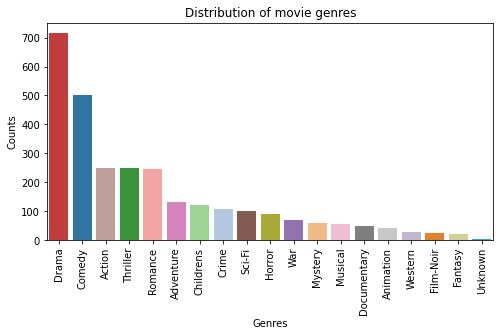

In [32]:
fig, ax = plt.subplots(figsize=(8,4))
counts = dict()
for i in movies.index:
    for g in movies.loc[i,'Genres'].split(','):
        if g not in counts:
            counts[g] = 1
        else:
            counts[g] = counts[g] + 1

counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}
sns.barplot(x=list(counts.keys()), y=counts.values(), palette=[colors_plot[key] for key in list(counts.keys())], hue=list(counts.keys()), legend=False)
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Counts')
plt.title('Distribution of movie genres')
plt.show()

The 'Drama' and 'Comedy' genres are the two highest represented genre categories. The genres 'Animation', 'Western', 'Fantasy', 'Film-Noir' and 'Unknown' have the lowest representation.

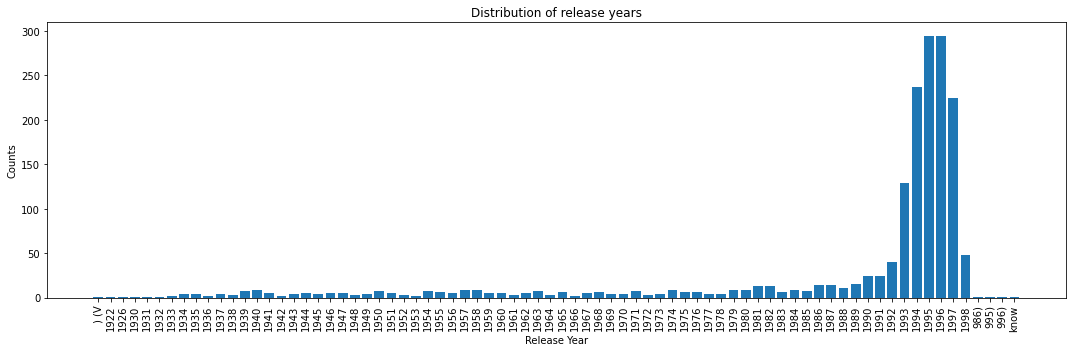

In [33]:
fig, ax = plt.subplots(figsize=(15,5))
counts = dict()
for i in movies.index:
    for g in movies.loc[i,'Release_Year'].split(','):
        if g not in counts:
            counts[g] = 1
        else:
            counts[g] = counts[g] + 1
            
counts = dict(sorted(counts.items()))
plt.bar(list(counts.keys()), counts.values())
plt.xticks(rotation=90)
plt.xlabel('Release Year')
plt.ylabel('Counts')
plt.title('Distribution of release years')
plt.tight_layout()
plt.show()

The dataset contains wrongly formatted movie information as we can see that we have also extracted non-year values. Fix: ToDo .

Apart from this, we can see that most movies in the dataset are from 1995 and 1996, as well as the surrounding years.

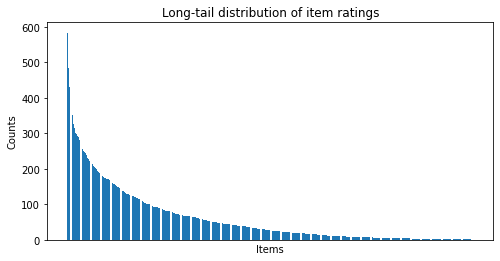

In [34]:
fig, ax = plt.subplots(figsize=(8,4))
movies_ct = []
for i in ratings['Movie_Id']:
    movies_ct.append(str(i))

counts = Counter(movies_ct)
counts = OrderedDict(counts.most_common())

plt.bar(list(counts.keys()), counts.values())
plt.xticks([])
plt.xlabel('Items')
plt.ylabel('Counts')
plt.title('Long-tail distribution of item ratings')
plt.show()

Very few movies have been rated a high number of times, while many movies have been only rated a a fraction of those top-rated movies.

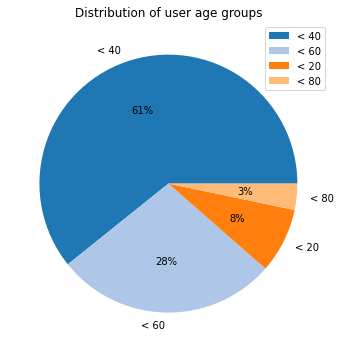

In [35]:
plt.figure(figsize=(7,5))
    
counts = dict()
for user_id in user_ages:
    age = f'< {user_ages[user_id]}'
    if age not in counts:
        counts[age] = 1
    else:
        counts[age] += 1
counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}

plt.pie(counts.values(), labels=list(counts.keys()), colors=plt.cm.tab20.colors, autopct='%.0f%%') 
plt.title(f'Distribution of user age groups')
plt.legend()
plt.tight_layout()
plt.show()

With 61%, most users belong to the age group 20-40, the smallest age group are the 60-80 years olds with 3%.

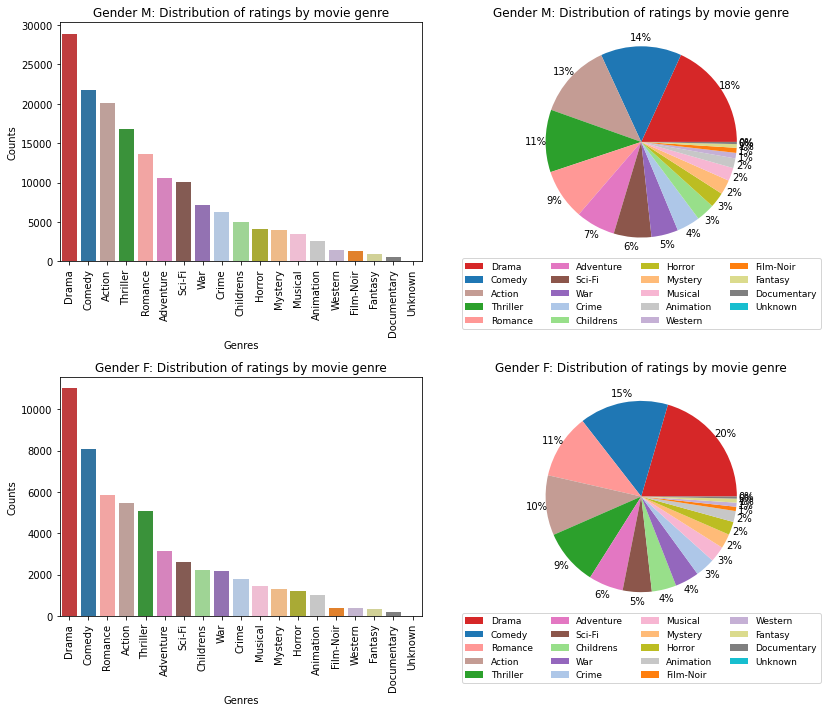

In [36]:
i=1
plt.figure(figsize=(12,10))
for gender in gender_genres:
    
    counts = dict()
    for genre in gender_genres[gender]:
        if genre not in counts:
            counts[genre] = 1
        else:
            counts[genre] += 1
    counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}
    
    plt.subplot(2,2,i)
    sns.barplot(x=list(counts.keys()), y=counts.values(), palette=[colors_plot[key] for key in list(counts.keys())], hue=list(counts.keys()), legend=False)
    plt.xticks(rotation=90)
    plt.xlabel(f'Genres')
    plt.ylabel('Counts')
    plt.title(f'Gender {gender}: Distribution of ratings by movie genre')
    i+=1
    plt.subplot(2,2,i)
    plt.pie(counts.values(), labels=None, colors=[colors_plot[key] for key in list(counts.keys())], autopct='%.0f%%', pctdistance=1.1)
    plt.title(f'Gender {gender}: Distribution of ratings by movie genre')
    plt.legend(labels=list(counts.keys()), loc='lower center',  ncol=4, fontsize=9, bbox_to_anchor=(0.5, -0.3), fancybox=True)
    
    
    i+=1
plt.tight_layout()
plt.show()


Both male and female users have rated 'Drama' and 'Comedy' movies the most. While for male users 'Action' movies are the third most rated genre, for female users this place is taken by 'Romance' movies. 'Documentary' and 'Fantasy' movies are the two least rated genres for both male and female users.

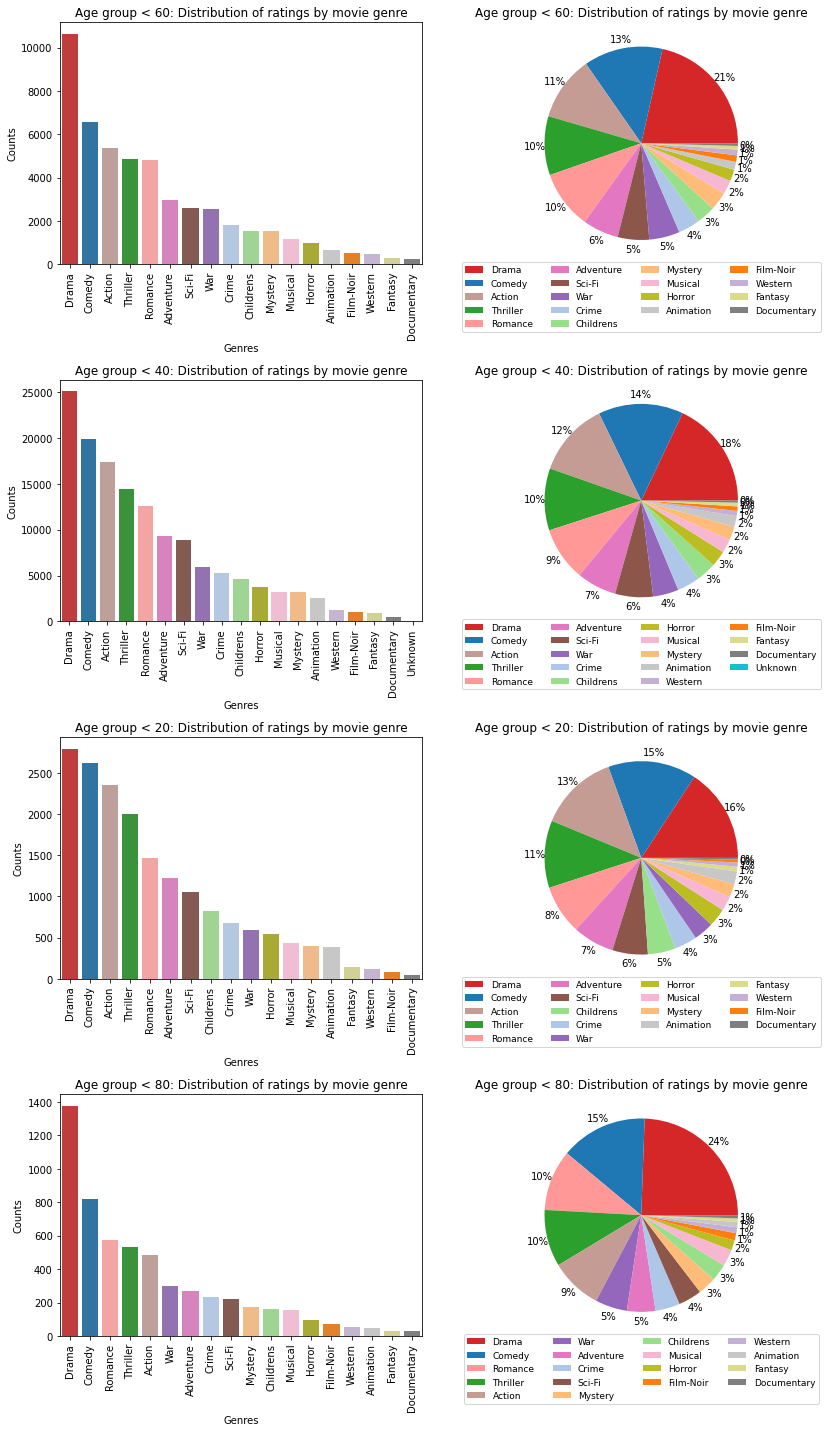

In [37]:
i=1
plt.figure(figsize=(12,20))
for age in age_genres:
    
    counts = dict()
    for genre in age_genres[age]:
        if genre not in counts:
            counts[genre] = 1
        else:
            counts[genre] += 1
    counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}
    
    plt.subplot(4,2,i)
    sns.barplot(x=list(counts.keys()), y=counts.values(), palette=[colors_plot[key] for key in list(counts.keys())], hue=list(counts.keys()), legend=False)
    plt.xticks(rotation=90)
    plt.xlabel(f'Genres')
    plt.ylabel('Counts')
    plt.title(f'Age group < {age}: Distribution of ratings by movie genre')
    i+=1
    plt.subplot(4,2,i)
    plt.pie(counts.values(), labels=None, colors=[colors_plot[key] for key in list(counts.keys())], autopct='%.0f%%', pctdistance=1.1)
    plt.title(f'Age group < {age}: Distribution of ratings by movie genre')
    plt.legend(labels=list(counts.keys()), loc='lower center',  ncol=4, fontsize=9, bbox_to_anchor=(0.5, -0.3), fancybox=True)
    i+=1
    
plt.tight_layout()
plt.show()

In all age groups 'Drama' movies are the most rented genre, closely followed by 'Comedy' movies. In the age groups <20, <40 and <60, the genre 'Action' is the third most rated. For users <80 the third most rated genre is 'Romance'. Ignoring the 'Unknown' genre tag, 'Documentary' movies are the least rated for all user groups. Age group <80 showed the highest interest in 'War' movies in comparison to the other age groups. Age groups <60 and <80 show the comparable lowest interest in 'Horror' movies. Users of age group <40 are the only ones, which have rated movies containing the 'Unknown' genre tag.

## Content-based movie recommendation using BERT (distilbert-base-nli-mean-tokens)
### the recommender currently does not take rating information into consideration but bases the recommendations on all watched movies
#### The recommender takes movie titles and movie genre information into consideration for recommendations


In [38]:
device = torch.device('cpu')
model = SentenceTransformer('distilbert-base-nli-mean-tokens')


In [39]:
def recommend_similar_movies(cos_sim_data, movie_index, top_k):
    index_recomm =cos_sim_data.loc[movie_index].sort_values(ascending=False).index.tolist()[1:(top_k+1)]
    movies_recomm =  movies['Title'].loc[index_recomm].values
    
    print(f"Watched movie: {movies['Title'].loc[movie_index]} \t Genres = {movies['Genres'].loc[movie_index]}")
    print(f"top-{top_k} similar recommendations:")
    k=1
    for m, movie in enumerate(movies_recomm):
        print('{:<5}{:<40}{:<50}'.format(f"{k}.", f"{movie}",f"Genres = {movies['Genres'].loc[index_recomm[m]]}"))
        k=k+1

In [40]:
def show_user_genres(user_movies, user_index, title=''):
    try:
        counts = dict()
        for i in user_movies.index:
            for g in user_movies.loc[i,'Genres'].split(','):
                if g not in counts:
                    counts[g] = 1
                else:
                    counts[g] = counts[g] + 1
    except:
        counts = Counter(user_movies)
        
    counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}
    
    sns.barplot(x=list(counts.keys()), y=counts.values(), palette=[colors_plot[key] for key in list(counts.keys())], hue=list(counts.keys()), legend=False)  
    plt.xticks(rotation=90)
    plt.xlabel('Genres')
    plt.ylabel('Counts')
    plt.title(title)
    

In [45]:
def make_recommendations_for_user(user_index, top_k): 
    rated_movies = ratings.loc[ratings['User_Id'] == user_index]['Movie_Id'].values
    user_movies = movies.loc[movies.index.isin(rated_movies)]
        
    remaining_movies = pd.merge(movies, user_movies, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
    
    text_data = ''

    for ind in user_movies.index: 
        text_data = text_data + ',' + user_movies['Title'][ind] + ',' + user_movies['Genres'][ind]

    embeddings_user = model.encode(text_data)
    embeddings_user = np.array(embeddings_user)

    cos_sim_data1 = pd.DataFrame(cosine_similarity([embeddings_user], embeddings))
    cos_sim_data1 = cos_sim_data1.T
    cos_sim_data1 = cos_sim_data1.loc[cos_sim_data1.index.isin(remaining_movies.index.values)]
    cos_sim_data1 = cos_sim_data1.T
    
    index_recomm =cos_sim_data1.loc[0].sort_values(ascending=False).index.tolist()[1:(top_k+1)]
    movies_recomm =  movies['Title'].loc[index_recomm].values
    
    print(f"top-{top_k} previously unrated movie recommendations for user {user_index}:")
    k=1
    new_genres = []
    for m, movie in enumerate(movies_recomm):
        genres = movies['Genres'].loc[index_recomm[m]]
        new_genres = new_genres + genres.split(',')
        print('{:<5}{:<40}{:<50}'.format(f"{k}.", f"{movie}",f"Genres = {genres}"))
        k=k+1
    
    plt.figure(figsize=(15,4))
    i = 1
    plt.subplot(1,2,i)
    show_user_genres(user_movies, user_index, title=f'Genre interests of user {user_index} (all ratings)')
    i += 1
    plt.subplot(1,2,i)
    show_user_genres(new_genres, user_index, title=f'Genre distribution of recommendations for user {user_index}')
    plt.show()
    

## Run test recommendations

In [42]:
text_data = movies['Title'] + ',' + movies['Genres']
embeddings = model.encode(text_data, show_progress_bar=True)
X = np.array(embeddings)
cos_sim_data = pd.DataFrame(cosine_similarity(X))

Batches: 100%|█████████████████████████████████████████████████████████████████████████| 52/52 [00:24<00:00,  2.16it/s]


In [43]:
recommend_similar_movies(cos_sim_data, movie_index=0, top_k=5)

Watched movie: Toy Story 	 Genres = Animation,Childrens,Comedy
top-5 similar recommendations:
1.   Aladdin                                 Genres = Animation,Childrens,Comedy,Musical       
2.   Kazaam                                  Genres = Childrens,Comedy,Fantasy                 
3.   Fantasia                                Genres = Animation,Childrens,Musical              
4.   Hercules                                Genres = Adventure,Animation,Childrens,Comedy,Musical
5.   Little Rascals, The                     Genres = Childrens,Comedy                         


#### The top-5 recommended movies based on their similarity to the exemplary movie (Toy Story) show high consistency with regard to the movie genres.

top-10 previously unrated movie recommendations for user 1:
1.   Big Lebowski, The                       Genres = Comedy,Crime,Mystery,Thriller            
2.   House of Yes, The                       Genres = Comedy,Drama,Thriller                    
3.   Batman                                  Genres = Action,Adventure,Crime,Drama             
4.   Alien 3                                 Genres = Action,Horror,Sci-Fi,Thriller            
5.   Jumanji                                 Genres = Action,Adventure,Childrens,Fantasy,Sci-Fi
6.   Ghost                                   Genres = Comedy,Romance,Thriller                  
7.   Aladdin and the King of Thieves         Genres = Animation,Childrens,Comedy               
8.   E.T. the Extra-Terrestrial              Genres = Childrens,Drama,Fantasy,Sci-Fi           
9.   Radioland Murders                       Genres = Comedy,Mystery,Romance                   
10.  Super Mario Bros.                       Genres = Action,Adventure,Child

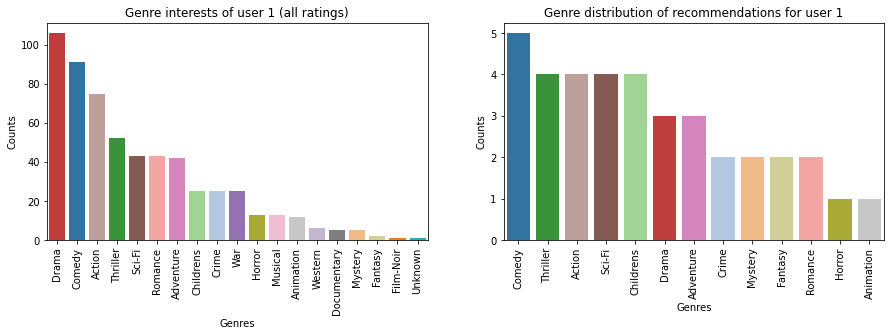

In [46]:
make_recommendations_for_user(user_index=1, top_k=10)

#### 4 out of the exemplary users' top-5 most-rated genres are also in the top-5 of the recommended movies' genres.